In [119]:
## this Block of code is for getting nearby properties from realtor.com
# it uses the requests library to make a GET request to the realtor.com API
# and retrieves properties based on latitude and longitude coordinates.
# the response is in JSON format and is printed to the console
# the code uses the requests library to make HTTP requests
# the json library is used to parse the response
# Api key is stored in an environment variable for security
import requests
import json
import pandas as pd
import os 
url = "https://realtor-com4.p.rapidapi.com/properties/get-nearby"

api_key = os.getenv('API_KEY')
querystring = {"lat":"40.78756","lon":"-73.969246", "limit":"100"}

headers = {
	"x-rapidapi-key": api_key, 
	"x-rapidapi-host": "realtor-com4.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

#print(response.json())



In [120]:
# the response is in JSON format
# AND it is parsed to extract the 'data' field AND the 'home_search' field
# the data is then printed to the console

JSONContent = response.json()
#print(JSONContent['data']['home_search'])


In [121]:
# the data is then converted to a into two pandas DataFrame objects 
# the 'results' field is used as the record path for the first DataFrame
# the 'current_estimates' field is used as the record path for the second DataFrame


df = pd.json_normalize(JSONContent['data']['home_search'],record_path=['results'],meta=['count'], errors='ignore')
current_estiamtes = pd.json_normalize(JSONContent['data']['home_search']['results'],'current_estimates',['property_id'])
df.info()
current_estiamtes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   __typename                      100 non-null    object 
 1   current_estimates               100 non-null    object 
 2   href                            100 non-null    object 
 3   list_price                      100 non-null    int64  
 4   listing_id                      100 non-null    object 
 5   permalink                       100 non-null    object 
 6   property_id                     100 non-null    object 
 7   status                          100 non-null    object 
 8   description.__typename          100 non-null    object 
 9   description.baths               100 non-null    int64  
 10  description.baths_consolidated  99 non-null     object 
 11  description.baths_full          99 non-null     float64
 12  description.baths_half          31 no

In [122]:
print(df.shape)

(100, 23)


In [123]:
# then data type for date is set to datetime category
# and then the data is grouped by property_id and the maximum date is selected
# the _typename column is dropped from the DataFrame
current_estiamtes['date'] = pd.to_datetime(current_estiamtes['date'])
current_estiamtes_max_date = current_estiamtes.loc[current_estiamtes.groupby('property_id')['date'].idxmax()]
current_estiamtes_max_date = current_estiamtes_max_date.drop(columns= ['__typename'])
current_estiamtes.head()
current_estiamtes_max_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 131 to 10
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              63 non-null     datetime64[ns]
 1   estimate          63 non-null     int64         
 2   isbest_homevalue  63 non-null     bool          
 3   property_id       63 non-null     object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 2.0+ KB


In [124]:
# the data is then merged with the first DataFrame using the property_id column
# Several unnecessary columns are dropped from the DataFrame
# and the final DataFrame is printed to the console 
description_listing = df.drop(columns=['__typename','description.__typename','location.__typename','location.address.__typename','count','current_estimates','permalink'])
description_listing = description_listing.merge(current_estiamtes_max_date, on='property_id', how='left')
description_listing.head(5)
print(description_listing.shape)


(100, 19)


In [125]:
# the columns are renamed to more meaningful names
description_listing = description_listing.rename(columns={'location.address.city':'city','location.address.state_code':'state','location.address.postal_code':'postal_code','location.address.line':'street',
                                                          'href':'url','description.baths':'baths','description.beds':'beds','description.sqft':'sqft','description.baths_consolidated':'baths_consolidated',
                                                          'description.baths_full':'baths_full','description.baths_half':'baths_half','date':'estimate_date','estimate':'estimate_property_value','description.lot_sqft':'lot_sqft'})
description_listing.head(5)


,url,list_price,listing_id,property_id,status,baths,baths_consolidated,baths_full,baths_half,beds,lot_sqft,sqft,city,street,postal_code,state,estimate_date,estimate_property_value,isbest_homevalue
0,https://www.realtor.com/realestateandhomes-det...,1999999,2977443152,3501051119,for_sale,2,2,2.0,NaN,2,NaN,1160.0,New York,45 E 89th St Apt 7D,10128,NY,2025-05-05,1572400.0,True
1,https://www.realtor.com/realestateandhomes-det...,2795000,2980324265,4113094547,for_sale,2,2,2.0,NaN,2,50250.0,NaN,Manhattan,45 E 89th St Apt 22C,10128,NY,2025-05-05,1694300.0,True
2,https://www.realtor.com/realestateandhomes-det...,2695000,2981727358,4665385261,for_sale,2,2,2.0,NaN,2,NaN,NaN,Manhattan,45 E 89th St Apt 32A,10128,NY,2025-05-05,2679100.0,True
3,https://www.realtor.com/realestateandhomes-det...,2795000,2981792806,4828535004,for_sale,2,2,2.0,NaN,2,50250.0,NaN,Manhattan,45 E 89th St Apt 23A,10128,NY,2025-05-05,2022800.0,True
4,https://www.realtor.com/realestateandhomes-det...,6250000,2981579733,9231886045,for_sale,7,6.5,6.0,1.0,9,NaN,6395.0,New York,13 W 89th St,10024,NY,NaT,NaN,NaN


In [126]:
# estimate_v_list_price column is created to indicate whether the property is underpriced, overpriced, or has no estimate
# it's comapare the lasted estimate_property_value with the list_price
import numpy as np

description_listing['estimate_v_list_price'] =  np.where(description_listing ['estimate_property_value'] > description_listing['list_price'], 'Underpriced',
                                                         np.where(description_listing ['estimate_property_value'].isnull(), 'No Estimate',
                                                                   'Overpriced'))
# Null values are dropped from the DataFrame
# and duplicates are removed based on the property_id column
description_listing_DV = description_listing.dropna(subset=['sqft','baths','beds','list_price'])
#description_listing = description_listing.drop_duplicates(subset=['property_id'])
# the final DataFrame is printed to the console

description_listing.head(5)

,url,list_price,listing_id,property_id,status,baths,baths_consolidated,baths_full,baths_half,beds,lot_sqft,sqft,city,street,postal_code,state,estimate_date,estimate_property_value,isbest_homevalue,estimate_v_list_price
0,https://www.realtor.com/realestateandhomes-det...,1999999,2977443152,3501051119,for_sale,2,2,2.0,NaN,2,NaN,1160.0,New York,45 E 89th St Apt 7D,10128,NY,2025-05-05,1572400.0,True,Overpriced
1,https://www.realtor.com/realestateandhomes-det...,2795000,2980324265,4113094547,for_sale,2,2,2.0,NaN,2,50250.0,NaN,Manhattan,45 E 89th St Apt 22C,10128,NY,2025-05-05,1694300.0,True,Overpriced
2,https://www.realtor.com/realestateandhomes-det...,2695000,2981727358,4665385261,for_sale,2,2,2.0,NaN,2,NaN,NaN,Manhattan,45 E 89th St Apt 32A,10128,NY,2025-05-05,2679100.0,True,Overpriced
3,https://www.realtor.com/realestateandhomes-det...,2795000,2981792806,4828535004,for_sale,2,2,2.0,NaN,2,50250.0,NaN,Manhattan,45 E 89th St Apt 23A,10128,NY,2025-05-05,2022800.0,True,Overpriced
4,https://www.realtor.com/realestateandhomes-det...,6250000,2981579733,9231886045,for_sale,7,6.5,6.0,1.0,9,NaN,6395.0,New York,13 W 89th St,10024,NY,NaT,NaN,NaN,No Estimate


In [127]:
description_listing.shape

(100, 20)

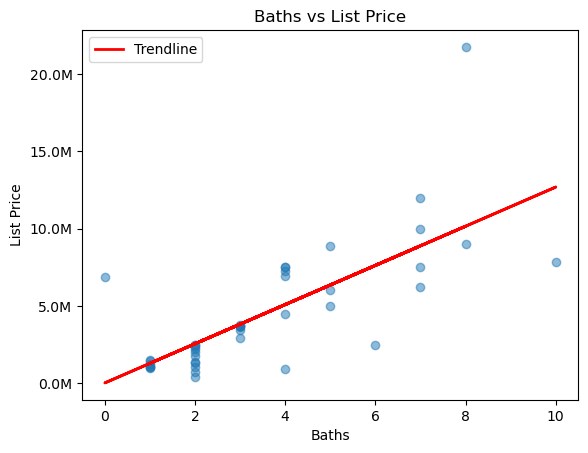

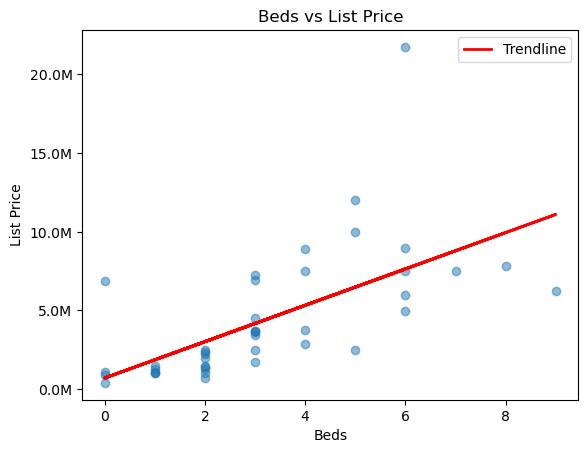

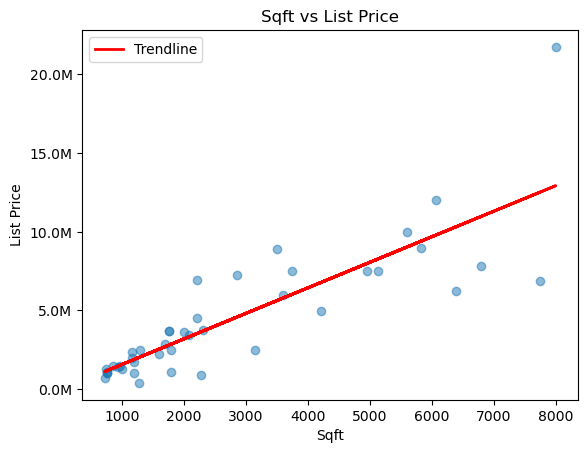

In [128]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
#function is created to plot scatter plots
def plot_scatter(x, y, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)
    coeffs = np.polyfit(x, y, 1)
    trendline = np.poly1d(coeffs)
    ax.plot(x, trendline(x), color='red', linewidth=2, label='Trendline')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

    plt.show()

plot_scatter(description_listing_DV['baths'], description_listing_DV['list_price'], 'Baths vs List Price', 'Baths', 'List Price')
plot_scatter(description_listing_DV['beds'], description_listing_DV['list_price'], 'Beds vs List Price', 'Beds', 'List Price')
plot_scatter(description_listing_DV['sqft'], description_listing_DV['list_price'], 'Sqft vs List Price', 'Sqft', 'List Price')



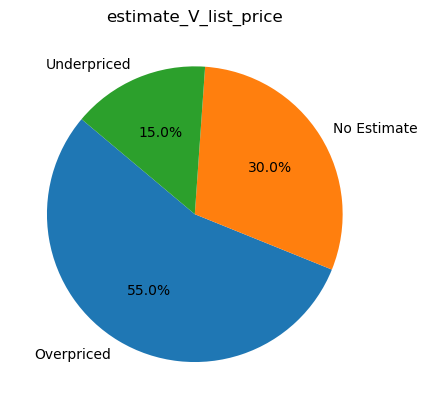

In [129]:
esitmate_v_list_price_count = description_listing['estimate_v_list_price'].value_counts()
plt.pie( esitmate_v_list_price_count ,labels = esitmate_v_list_price_count.index,autopct='%1.1f%%', startangle=140)
plt.title("estimate_V_list_price")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
#Using Bed, bath, and sqft to determine price
X = description_listing[['baths','beds','sqft']]
Y = description_listing['list_price']
#split the model into test and train data set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean absolute error: {mae}")
print(f"R-squared Score: {r2}")


Mean absolute error: 824701.8263806239
R-squared Score: 0.8084452780788671


In [ ]:
#so next step's are feature engieering and that would be encoding the zipcode.

from sklearn.preprocessing import OneHotEncoder
# Initialize encoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

zip_encoded = encoder.fit_transform(description_listing[['postal_code']])
zip_df = pd.DataFrame(zip_encoded, columns=encoder.get_feature_names_out(['postal_code']))

zip_df.index = description_listing.index

X = pd.concat([description_listing[['baths','beds','sqft']],zip_df], axis = 1)
Y = description_listing['list_price']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean absolute error: {mae}")
print(f"R-squared Score: {r2}")


Mean absolute error: 878952.1864006091
R-squared Score: 0.7777807862783461


In [ ]:
#Cleaning the streat address to push througha an API to get the Neighboorhood for future feature engieering
import re

#removes the appartment from the streat address
def clean_street(address):
    return re.sub(r'\s?(Apt|Unit|Ph|#)\s?\w+', '', address, flags=re.IGNORECASE)

# Apply to your DataFrame
description_listing['clean_street'] = description_listing['street'].apply(clean_street)
#Concatenate the clean street, city and postal code to get the full address
description_listing['full_address'] = description_listing['clean_street'] + ', ' + description_listing['city'] + ', ' + description_listing['postal_code'].astype(str)


In [135]:
description_listing.shape

(100, 22)